In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(ggrepel)
library(reshape2)
library(ggsci)
library(rstatix)
library(ggpubr)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




# Color Dict

In [2]:
color_annotation<-read.csv('/home//jupyter/BRI_Figures_Final_V2/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read FreqChanges and DEG number 

In [3]:
df<-read.csv("03_Frequency_Changes//FreqChanges_and_DEG.csv")

In [4]:
labels_vector<-c("Core naive CD8 T cell","CM CD8 T cell","GZMK+ CD27+ EM CD8 T cell","Naive CD4 Treg",
                 "Core naive CD4 T cell","CM CD4 T cell","GZMB- CD27- EM CD4 T cell","GZMB- CD27+ EM CD4 T cell")

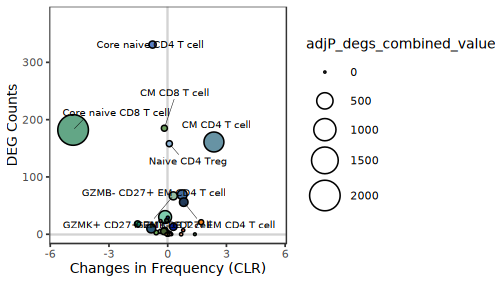

In [9]:
options(repr.plot.width = 106/25.4, repr.plot.height = 60/25.4)


p <- ggplot(df, aes(x = delta_change, y = DEG_Counts, size = adjP_degs_combined_value, fill = AIFI_L3)) +
  geom_hline(yintercept = 0, color = "lightgray", size = 0.5) + 
  geom_vline(xintercept = 0, color = "lightgray", size = 0.5) + 
  geom_point(shape = 21, colour = "black") +
  theme_bw(base_size = 8) +
  scale_size_continuous(range = c(0, 8), limits = c(0, max(df$adjP_degs_combined_value))) +
  xlab("Changes in Frequency (CLR)") +
  ylab("DEG Counts") +
  theme(legend.position = "right") +
  scale_fill_manual(values = color_vector) +
  scale_x_continuous(limits = c(-5.5, 5.5)) +
  guides(fill = "none", size = guide_legend("adjP_degs_combined_value")) + 
  geom_text_repel(
    data = df %>% filter(AIFI_L3 %in% labels_vector),
    box.padding = 0.5,
    force = 0.5,
    max.overlaps = 50,
    nudge_x = 0.15,
    hjust = 0.1,
    segment.size = 0.1,
    mapping = aes(label = AIFI_L3),
    size = 2
  ) +
  theme(
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank()   # Remove minor grid lines
  )+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.2)))

print(p)
ggsave(filename = "FigureE.pdf", plot = p, width = 106/25.4, height = 60/25.4)
